# Importing and data cleaning 

In [2]:
import pandas as pd 

dem= pd.read_csv('oasis_longitudinal.csv')

print(dem.shape)
dem = pd.DataFrame(dem)

#recoding gender to 0 male and 1 female, needed for knn analysis later

dem['M/F']= pd.get_dummies(dem['M/F']) #male has become 0 and female has become 1

dem.head(20)

#Removing na's from dataset 
dem.dropna(inplace = True, subset = ['SES']) # drops all rows only if SES has a NA value. 
print(dem.isnull().any()) 
dem.columns
dem.shape




(373, 15)
Subject ID    False
MRI ID        False
Group         False
Visit         False
MR Delay      False
M/F           False
Hand          False
Age           False
EDUC          False
SES           False
MMSE          False
CDR           False
eTIV          False
nWBV          False
ASF           False
dtype: bool


(354, 15)

# Scaling features 

In [3]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
dem.iloc[:,[7,8,9]]= scalar.fit_transform(dem.iloc[:,[7,8,9]]) #rescaling age,education and socioeconomic status but not gender
dem

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,0,R,1.277580,-0.243255,-0.406615,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,0,R,1.405772,-0.243255,-0.406615,30.0,0.0,2004,0.681,0.876
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,1,R,1.405772,1.140076,0.476463,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,1,R,1.662157,1.140076,0.476463,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,0,R,0.380232,-0.934921,1.359542,28.0,0.0,1689,0.712,1.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,0,R,0.636617,0.448410,-1.289694,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,0,R,1.149387,0.448410,-1.289694,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,1,R,-2.055426,-0.589088,-0.406615,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,1,R,-1.799041,-0.589088,-0.406615,30.0,0.0,1327,0.796,1.323


# Class distribution of dataset 

In [4]:
dem.groupby('Group').size() #converted means coverted to dementia during the study 

Group
Converted       37
Demented       127
Nondemented    190
dtype: int64

# Univariate plot 

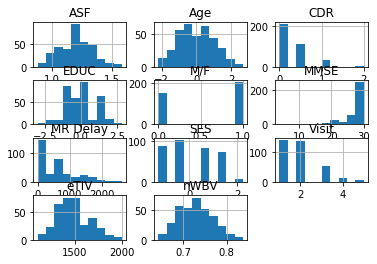

In [5]:
import matplotlib.pyplot as plt
dem.hist()
plt.show() #age is normally distributed 

# Multivariate plot 

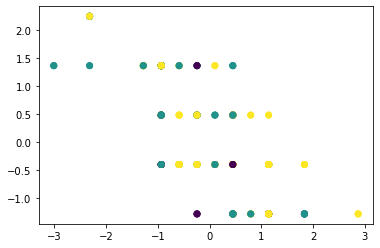

In [7]:
#recoding to integers for dementia classes.

Dict = {'Converted': 0,
       'Demented': 1,
       'Nondemented':2}

colors = [Dict[item] for item in dem['Group']]
scatter = plt.scatter(dem['EDUC'], dem['SES'], c = colors)


# Modelling with KNN

In [8]:
features = dem[['Age', 'M/F', 'EDUC', 'SES']]

target = dem['Group']

from sklearn.model_selection import train_test_split

feat_train, feat_test, targ_train, targ_test = train_test_split(features, target,
                                                               test_size = 0.3,
                                                               random_state = 1,
                                                                stratify = target)

print(targ_train.value_counts())
print(targ_test.value_counts())

#statify ensures train/test splits are proportional to the whole dataset classes

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)  #instantiating 

#training the model 

knn.fit(feat_train, targ_train) #using default minkowski distance metric to fit the model



Nondemented    132
Demented        89
Converted       26
Name: Group, dtype: int64
Nondemented    58
Demented       38
Converted      11
Name: Group, dtype: int64


KNeighborsClassifier()

# Prediction 

## Label prediction

In [9]:
targ_pred = knn.predict(feat_test) #using model on unseen test data to predict labels 
print(targ_pred[:5]) 

['Nondemented' 'Demented' 'Nondemented' 'Nondemented' 'Converted']


## probability prediction

In [10]:
targ_pred_prob = knn.predict_proba(feat_test) 
print(targ_pred_prob[:5]) #100% chance first observation is non demented, 100% chance second obs is demented
#soft prediction whereas hard is 

print(targ_pred[:5]) #just selects the label but no prob towards each label.

[[0.  0.  1. ]
 [0.  1.  0. ]
 [0.  0.2 0.8]
 [0.  0.2 0.8]
 [0.6 0.  0.4]]
['Nondemented' 'Demented' 'Nondemented' 'Nondemented' 'Converted']


# Model evaluation

In [11]:
print(targ_test.size)
print((targ_pred == targ_test).sum()) 

print((targ_pred == targ_test).sum()/targ_test.size) #The model got 59% accurate at classifying 



107
63
0.5887850467289719


# Confusion matrix

In [12]:
#Classification accuracy alone can be misleading if there is an unequal number of observations in each class or if there 
#are more than two classes in the dataset. Calculating a confusion matrix will provide a better idea of what the 
#classification is getting right and what types of errors it is making.

from sklearn.metrics import confusion_matrix

confusion_matrix(targ_test, targ_pred, labels = ['Converted', 'Demented','Nondemented'])




array([[ 3,  2,  6],
       [ 1, 22, 15],
       [ 4, 16, 38]], dtype=int64)

# K-fold cross validation 

In [89]:
from sklearn.model_selection import cross_val_score

knn_cv = KNeighborsClassifier(n_neighbors = 3) #new knn model

#fitting 3 nearest neighbor model 

cv_scores = cross_val_score(knn_cv, features, target, cv =5 ) #5-fold 

print(cv_scores)
print(cv_scores.mean()) #accuracy only 47% when we average them all! 




[0.45070423 0.6056338  0.50704225 0.47887324 0.35714286]
0.4798792756539235


# Grid searching

In [18]:
from sklearn.model_selection import GridSearchCV

import numpy as np

knn2 = KNeighborsClassifier()

#creating a dict to test all values of n_neighbors 

param_grid = {'n_neighbors':np.arange(2,10)}

#Use gridsearch to test all values for n_neighbors

knn_gscv = GridSearchCV(knn2, param_grid, cv = 5)

#fit model to data 

knn_gscv.fit(features,target)

#to check top n_neighbors value
print(knn_gscv.best_params_) 

#what is the accuracy when neighbors = 7

knn_gscv.best_score_ # finding optimal hyperparameter improved model by 3%. 50% all up

#Now to build final model 

knn_final = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors']) #indexing n_neighbors makes sure we print out 7 instead of
#the dictionary key with the value 7

#print(knn_gscv.best_params_) #this would do dict with value

knn_final.fit(features,target)
targ_pred = knn_final.predict(features)
knn_final.score(features,target) #predicts dementia presense at 73% which is a marked improvement of 50%

{'n_neighbors': 7}


0.7372881355932204

# Extra: label prediction with new data

In [102]:
print(features.head(10))
new_data = np.array([1.277580, 0, -0.243255, -0.406615]) #should predict non demented

new_data = new_data.reshape(1,-1) #will make it compatible or can just use two square brackets for new_data to mean 2D

new_data.shape

print(knn_final.predict(new_data)) #got it wrong!
 



         Age  M/F      EDUC       SES
0   1.277580    0 -0.243255 -0.406615
1   1.405772    0 -0.243255 -0.406615
5   1.405772    1  1.140076  0.476463
6   1.662157    1  1.140076  0.476463
7   0.380232    0 -0.934921  1.359542
8   0.764810    0 -0.934921  1.359542
9   1.021195    0 -0.934921  1.359542
13  2.046735    1 -0.243255 -0.406615
14  2.303120    1 -0.243255 -0.406615
15 -1.158078    0 -0.934921 -0.406615
['Converted']
